In [12]:
%cd /om2/user/valmiki/bioplnn/

/rdma/vast-rdma/user/valmiki/bioplnn


/om2/user/valmiki/miniconda/envs/pytorch-3.10/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import glob
import scipy
import os
from bioplnn.dataset import CIFAR10_V1
import matplotlib.pyplot as plt
from bioplnn.utils import flatten_indices


In [3]:
transform = transforms.Compose(
            [transforms.ToTensor()])
trainset = CIFAR10_V1(root='./data', train=True, retina_path="connection",
                                    download=True, transform=transform)

Files already downloaded and verified


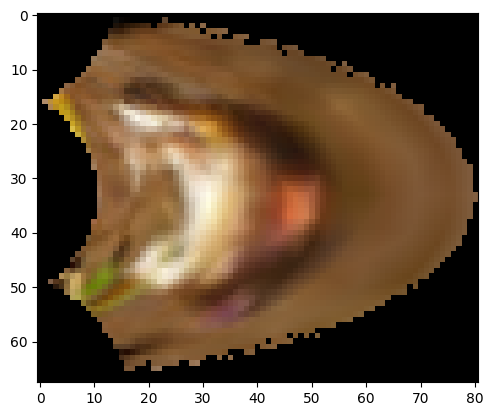

In [14]:
plt.imshow(trainset[0][0].transpose(0, 2))

In [ ]:
class ConvRNN(nn.Module):
    def __init__(self, input_size, kernel_size):
        super(ConvRNN, self).__init__()
        self.conv = nn.Conv2d(input_size, input_size, kernel_size, padding=1)
        self.conv.register_full_backward_hook(lambda _, __, ___: print(1))

    def forward(self, x):
        for _ in range(10):
            x = F.relu(self.conv(x))
        return x

# Example usage
input_size = 3
kernel_size = 3
height = 32
width = 32

model = ConvRNN(input_size, kernel_size)
input_data = torch.randn(16, input_size, height, width)
output = model(input_data)
loss = output.sum()
loss.backward()


In [3]:
x = torch.randn(16, 3, 32, 32, requires_grad=True)
conv = torch.nn.Conv2d(3, 3, 3, padding=1)
conv.weight.register_hook(lambda grad: print(1))
for _ in range(10):
    x = F.relu(conv(x))
loss = x.sum()
loss.backward()

1


In [3]:
def build_graph(path):
    connection = {}
    coordinates = []
    Nunits = []
    Adj = []
    weight_path = glob.glob(os.path.join(path, '*.npz'))[0]
    sparse_connection = scipy.sparse.load_npz(weight_path)
    mask_path = glob.glob(os.path.join(path, '*.npy'))
    if len(mask_path) == 1:
        masks = np.load(mask_path[0])
        layers = [np.stack(mask.nonzero()) for mask in masks[:-1]]
        Ny = masks.shape[2]
    else:
        layers = ['V1_indices', 'V2_indices', 'V3_indices', 'V4_indices']
        layers = [np.load(os.path.join(path, f'{layer}.npy')) for layer in layers]
        Ny = 300
    
    for coor in layers:
        coordinates.append(coor[0] * Ny + coor[1])

    for i, incoming in enumerate(coordinates[:-1]):
        adj = torch.from_numpy(sparse_connection[coordinates[i+1]][:, incoming].toarray()).float()
        Adj.append(adj)

    return Adj

In [14]:
path = "connection"
weight_path = os.path.join(path, 'sparse.npz')
sparse_connection = scipy.sparse.load_npz(weight_path)

In [15]:
sparse_connection = torch.load(os.path.join(path, 'sparse.pt')).coalesce()

In [23]:
layers = ['V1_indices', 'V2_indices', 'V3_indices', 'V4_indices']
coordinates = [torch.tensor(np.load(os.path.join(path, f'{layer}.npy'))) for layer in layers]
Ny = 300
coordinates1d = [flatten_indices(coor) for coor in coordinates]
for coor, layer in zip(coordinates, layers):
    torch.save(coor, os.path.join(path, f'{layer}.pt'))
for coor, layer in zip(coordinates1d, layers):
    torch.save(coor, os.path.join(path, f'{layer}_flat.pt'))

In [28]:
x = torch.zeros(16, 3, 1024)
x = x.flatten(2)
print(x.shape)
x.mean(dim=1).shape

torch.Size([16, 3, 1024])


torch.Size([16, 1024])

In [22]:
for layer in layers:
    os.remove(os.path.join(path, f'{layer}_flat.pt'))

In [16]:
sparse_connection = sparse_connection.to('cuda')

In [29]:
indices = sparse_connection.indices()
indices[1,:].unique()

tensor([   50,    51,    52,  ..., 31361, 31362, 31363], device='cuda:0')

In [36]:
values = torch.ones_like(coordinates[0]).float()

In [42]:
pic = torch.ones(150, 300)
for coordinate in coordinates:
    pic[coordinate[0], coordinate[1]] = 0

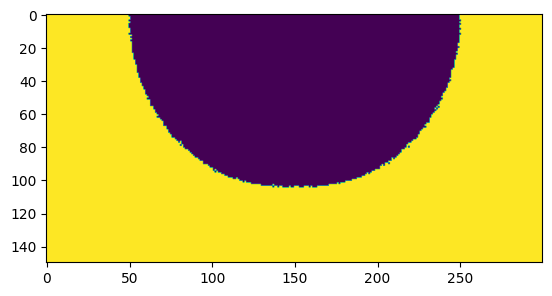

In [43]:
import matplotlib.pyplot as plt
plt.imshow(pic)

In [ ]:
torch.sparse_coo_tensor(coordinates[0], values, (150, 300), device='cuda').to_dense()